 ![FREYA Logo](https://github.com/datacite/pidgraph-notebooks-python/blob/master/images/freya_200x121.png?raw=true) | [FREYA](https://www.project-freya.eu/en) WP2 [User Story3](https://www.pidforum.org/t/pid-graph-graphql-example-research-organization/929) | As an administrator for the University of Oxford I am interested in the reuse of research outputs from our university, so that I can help identify the most interesting research outputs.
:------------- | :------------- | :-------------

It is important for research organisations to measure quality and quantity of their outputs as well as their relevance to latest global research trends and to their own strategic science direction.<p />
This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to retrieve up to 100 outputs (e.g. publications or datasets) from [University of Oxford](https://ror.org/052gg0110) in order to quantify and visualise their reuse.

**Goal**: By the end of this notebook, for a given organization, you should be able to display:
- Counts of citations, views and downloads metrics, aggregated across all of the organization's outputs;
- An interactive stacked bar plot showing how the metric counts of each of the following <ins>output characteristics</ins> contributes the corresponding aggregated metric counts:<br><ins>Type</ins>, <ins>Publication Year</ins>, <ins>Author Affiliation</ins> and <ins>DOI</ins>, e.g. <br><br><img src="example_plot.png" width="353" height="206" />
- A word cloud of words from output titles in which word size is determined by the <ins>aggregated citations, views and downloads count</ins> corresponding to all output titles in which it appears
- An interactive matrix diagram graph of affiliations of organization's outputs' authors, e.g. 
 - Affiliations are values on X and Y axes, and 
 - The rectangular cells in the matrix indicate that authors from the two respective affiliations shared at least one publication together.
 - Matrix cells are coloured differently depending on the geographic regions of the corresponding affiliations, e.g. <br><br><img src="vega_by_index.svg" width="370" height="320" />


## Install libraries and prepare GraphQL client

In [208]:
%%capture
# Install required Python packages
!pip install gql requests numpy plotly pyvis

In [209]:
# Prepare the GraphQL client
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)


## Define and run GraphQL query
Define the GraphQL query to retrieve up to 100 outputs (e.g. publications or datasets) from [University of Oxford](https://ror.org/052gg0110), using its **Research Organization Registry (ROR)** identifier.

In [187]:
# Generate the GraphQL query to retrieve up to 100 outputs of University of Oxford, with at least 100 views each.
query_params = {
    "rorId" : "https://ror.org/052gg0110",
    "maxOutputs": 100,
    "minViews" : 100
}

query = gql("""query getOutputs($rorId: ID!, $maxOutputs: Int!, $minViews: Int!)
{
 organization(id: $rorId) {
    id
    name
    alternateName
    citationCount
    viewCount
    downloadCount
    works(hasViews: $minViews, first: $maxOutputs) {
      totalCount
      published {
        title
        count
      }
      resourceTypes {
        title
        count
      }
      nodes {
        id
        type
        publisher
        publicationYear
        titles {
          title
        }
        citations {
           nodes {
             id
             titles {
                title
             }
           }
        }
        creators {
          id
          name
          affiliation {
            id
            name
          }
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

Run the above query via the GraphQL client

In [188]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

## Display total metric counts 
Display total number of <ins>citations, views and downloads</ins> of [University of Oxford](https://ror.org/052gg0110)'s outputs.

In [189]:
# Get the total count per metric, aggregated across all of the organization's outputs
organization = data['organization']
organizationName = organization['name']
# Initialise metric counts across all outputs of the organization
metricCounts = {}
for metric in ['citationCount', 'viewCount', 'downloadCount']:
    metricCounts[metric] = 0
    
# Aggregate metric counts across all the parts
for node in organization['works']['nodes']:
    for metric in metricCounts:
         metricCounts[metric] += node[metric]
            
# Display the aggregated metric counts
tableBody=""
for metric in metricCounts:        
    tableBody += "%s | **%s**\n" % (metric, str(metricCounts[metric]))
if tableBody:
   display(Markdown("Aggregated metric counts across %d outputs of [University of Oxford](https://ror.org/052gg0110):" % organization['works']['totalCount']))
   display(Markdown("|Metric | Aggregated Count|\n|---|---|\n%s" % tableBody))                                 

Aggregated metric counts across 78 outputs of [University of Oxford](https://ror.org/052gg0110):

|Metric | Aggregated Count|
|---|---|
citationCount | **6**
viewCount | **18970**
downloadCount | **7432**


## Plot metric counts per output type
Plot stacked bar plot showing how <ins>each type</ins> of [University of Oxford](https://ror.org/052gg0110)'s outputs contribute their metric counts to the corresponding aggregated total.

In [190]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
def px_stacked_bar(df, color_name='Metric', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)

# Collect metric counts
organization = data['organization']

# Initialise dicts for the stacked bar plot
labels = {0: 'All Output Types'}
citationCounts = {}
viewCounts = {}
downloadCounts = {}

# Collect output type labels
outputTypesSet = set([])
outputType2Pos = {}
for node in organization['works']['nodes']:
    outputTypesSet.add(node['type'])
outputTypes = list(outputTypesSet);    
for pos, outputType in enumerate(outputTypes):
    labels[pos + 1] = outputType
    outputType2Pos[outputType] = pos + 1
    
# Initialise metric counts
for pos, _ in enumerate(labels):
    citationCounts[pos] = 0
    viewCounts[pos] = 0
    downloadCounts[pos] = 0
# Populate metric counts per output type (key = i) and add them to the aggregated counts (key: 0)
for node in organization['works']['nodes']:
    pos = outputType2Pos[node['type']]
    citationCounts[0] += node['citationCount']
    viewCounts[0] += node['viewCount']
    downloadCounts[0] += node['downloadCount']
    citationCounts[pos] += node['citationCount']
    viewCounts[pos] += node['viewCount']
    downloadCounts[pos] += node['downloadCount']

# Create stacked bar plot
x_name = "%s's Output Types" % organizationName
df = pd.DataFrame({x_name: labels,
                   'Citations': citationCounts,
                   'Views': viewCounts,
                   'Downloads': downloadCounts})
fig = px_stacked_bar(df.set_index(x_name), y_name = "Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='ot_out.html')

# Display plot from the saved html file
display(Markdown("Citations, views and downloads for [University of Oxford](https://ror.org/052gg0110)'s outputs, shown per output type as stacked bar plot:"))
IFrame(src="./ot_out.html", width=500, height=500)

Citations, views and downloads for [University of Oxford](https://ror.org/052gg0110)'s outputs, shown per output type as stacked bar plot:

## Plot metric counts per year
Plot stacked bar plot showing how outputs of [University of Oxford](https://ror.org/052gg0110) in each year contribute their metric counts to the corresponding aggregated total.

In [191]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
def px_stacked_bar(df, color_name='Metric', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)

# Collect metric counts
organization = data['organization']

# Initialise dicts for the stacked bar plot
labels = {}
citationCounts = {}
viewCounts = {}
downloadCounts = {}

# Collect output type labels
outputPubYearsSet = set([])
outputPubYear2Pos = {}
for node in organization['works']['nodes']:
    if node['publicationYear'] != '':
        outputPubYearsSet.add(node['publicationYear'])
outputPubYears = list(outputPubYearsSet);    
for pos, outputPubYear in enumerate(outputPubYears):
    labels[pos] = outputPubYear
    outputPubYear2Pos[outputPubYear] = pos
    
# Initialise metric counts
for pos, _ in enumerate(labels):
    citationCounts[pos] = 0
    viewCounts[pos] = 0
    downloadCounts[pos] = 0
# Populate metric counts per output type (key = i) and add them to the aggregated counts (key: 0)
for node in organization['works']['nodes']:
    pos = outputPubYear2Pos[node['publicationYear']]
    citationCounts[pos] += node['citationCount']
    viewCounts[pos] += node['viewCount']
    downloadCounts[pos] += node['downloadCount']

# Create stacked bar plot
x_name = "Publication Years of %s's Outputs" % organizationName
df = pd.DataFrame({x_name: labels,
                   'Citations': citationCounts,
                   'Views': viewCounts,
                   'Downloads': downloadCounts})
fig = px_stacked_bar(df.set_index(x_name), y_name = "Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='yr_out.html')

# Display plot from the saved html file
display(Markdown("Citations, views and downloads counts of [University of Oxford](https://ror.org/052gg0110)'s outputs, shown per publication year as stacked bar plot:"))
IFrame(src="./yr_out.html", width=1000, height=500)

Citations, views and downloads counts of [University of Oxford](https://ror.org/052gg0110)'s outputs, shown per publication year as stacked bar plot:

## Plot metric counts per author affiliation
Plot stacked bar plot showing how individual author's affiliations of [University of Oxford](https://ror.org/052gg0110)'s outputs contribute their metric counts to the corresponding aggregated total. The plot shows <ins>top 30</ins> author affiliations (other than University of Oxford) by the <ins>combined citations, views and downloads count<ins>.

In [192]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd
from operator import itemgetter

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
# c.f. https://plotly.com/python-api-reference/generated/plotly.express.bar.html#plotly.express.bar
def px_stacked_bar(df, color_name='Metric', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)

MAX_TOP_AFFILIATIONS_BY_ALL_METRIC_COUNT=30

# Collect metric counts
organization = data['organization']
organizationName = organization['name']

# Initialise dicts for the stacked bar plot
labels = {}
citationCounts = {}
viewCounts = {}
downloadCounts = {}

# Collect output type labels
affiliationsSet = set([])
for node in organization['works']['nodes']:
    for creator in node['creators']:
        for affiliation in creator['affiliation']:
            affiliationsSet.add(affiliation['name'])
affiliations = list(affiliationsSet);    
    
# Retrieve metric counts by affiliation
affiliation2CitationCount = {}
affiliation2ViewCount = {}
affiliation2DownloadCount = {}
affiliation2AllMetricCount = {}
# Initialise metric counts
for an in affiliations:
    affiliation2CitationCount[an] = 0
    affiliation2ViewCount[an] = 0
    affiliation2DownloadCount[an] = 0
    affiliation2AllMetricCount[an] = 0
    
for node in organization['works']['nodes']:
    seenAffiliationInNode = set([])
    for creator in node['creators']:  
        for affiliation in creator['affiliation']:
            an = affiliation['name']
            if an not in seenAffiliationInNode: 
                affiliation2CitationCount[an] += node['citationCount']
                affiliation2ViewCount[an] += node['viewCount']
                affiliation2DownloadCount[an] += node['downloadCount']
                affiliation2AllMetricCount[an] += node['citationCount'] + node['viewCount'] + node['downloadCount']
                seenAffiliationInNode.add(an)         
# Initialise metric counts
for pos in range(len(affiliations)):
    citationCounts[pos] = 0
    viewCounts[pos] = 0
    downloadCounts[pos] = 0
    
# Populate metric counts per output type (key = pos)
pos = 0
for an, _ in sorted(affiliation2AllMetricCount.items(), key = itemgetter(1), reverse = True):
    if an != organizationName:
        labels[pos] = an
        citationCounts[pos] += affiliation2CitationCount[an]
        viewCounts[pos] += affiliation2ViewCount[an]
        downloadCounts[pos] += affiliation2AllMetricCount[an]
        pos += 1
    if pos >= MAX_TOP_AFFILIATIONS_BY_ALL_METRIC_COUNT:
        break;

# Create stacked bar plot
x_name = "Affiliations of %s's Output Authors" % organizationName
df = pd.DataFrame({x_name: labels,
                   'Citations': citationCounts,
                   'Views': viewCounts,
                   'Downloads': downloadCounts})
fig = px_stacked_bar(df.set_index(x_name), y_name = "Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='af_out.html')

# Display plot from the saved html file
display(Markdown("Citations, views and downloads counts across affiliations of authors of [University of Oxford](https://ror.org/052gg0110)'s outputs, shown as stacked bar plot.<br>The plot shows <ins>top 30</ins> author affiliations (other than University of Oxford) by the <ins>combined citations, views and downloads count<ins>."))
IFrame(src="./af_out.html", width=1000, height=800)

Citations, views and downloads counts across affiliations of authors of [University of Oxford](https://ror.org/052gg0110)'s outputs, shown as stacked bar plot.<br>The plot shows <ins>top 30</ins> author affiliations (other than University of Oxford) by the <ins>combined citations, views and downloads count<ins>.

## Plot metric counts per individual output
Plot stacked bar plot showing how individual outputs of [University of Oxford](https://ror.org/052gg0110)'s contribute their metric counts to the corresponding aggregated total. The plot shows DOIs of <ins>top 30</ins> outputs by the <ins>combined citations, views and downloads count<ins>.

In [193]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd
from operator import itemgetter

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
# c.f. https://plotly.com/python-api-reference/generated/plotly.express.bar.html#plotly.express.bar
def px_stacked_bar(df, color_name='Metric', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)

MAX_TOP_DOIS_BY_ALL_METRIC_COUNT=30

# Collect metric counts
organization = data['organization']
organizationName = organization['name']

# Initialise dicts for the stacked bar plot
labels = {}
citationCounts = {}
viewCounts = {}
downloadCounts = {}
    
# Retrieve metric counts by doi
doi2CitationCount = {}
doi2ViewCount = {}
doi2DownloadCount = {}
doi2AllMetricCount = {}

for node in organization['works']['nodes']:
    doi = node['id']
    doi2CitationCount[doi] = node['citationCount']
    doi2ViewCount[doi] = node['viewCount']
    doi2DownloadCount[doi] = node['downloadCount']
    doi2AllMetricCount[doi] = node['citationCount'] + node['viewCount'] + node['downloadCount']  
    
# Initialise metric counts
pos = 0;
for node in organization['works']['nodes']:
    citationCounts[pos] = 0
    viewCounts[pos] = 0
    downloadCounts[pos] = 0
    pos += 1
    
# Populate metric counts per output type (key = pos)
pos = 0
for doi, _ in sorted(doi2AllMetricCount.items(), key = itemgetter(1), reverse = True):
    labels[pos] = "<a href=\"%s\">%s</a>" % (doi, "/".join(doi.split("/")[3:]))
    citationCounts[pos] += doi2CitationCount[doi]
    viewCounts[pos] += doi2ViewCount[doi]
    downloadCounts[pos] += doi2AllMetricCount[doi]
    pos += 1
    if pos >= MAX_TOP_DOIS_BY_ALL_METRIC_COUNT:
        break;

# Create stacked bar plot
x_name = "%s's Output DOIs" % organizationName
df = pd.DataFrame({x_name: labels,
                   'Citations': citationCounts,
                   'Views': viewCounts,
                   'Downloads': downloadCounts})
fig = px_stacked_bar(df.set_index(x_name), y_name = "Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='doi_out.html')

# Display plot from the saved html file
display(Markdown("Citations, views and downloads counts for individual outputs of [University of Oxford](https://ror.org/052gg0110), shown as stacked bar plot.<br>The plot shows DOIs of <ins>top 30</ins> outputs by the <ins>combined citations, views and downloads count<ins>."))
IFrame(src="./doi_out.html", width=1000, height=800)

Citations, views and downloads counts for individual outputs of [University of Oxford](https://ror.org/052gg0110), shown as stacked bar plot.<br>The plot shows DOIs of <ins>top 30</ins> outputs by the <ins>combined citations, views and downloads count<ins>.

## Display a word cloud of output titles.
Display a word cloud of words from output titles in which word size is determined by the <ins>aggregated citations, views and downloads count</ins> corresponding to all output titles in which it appears.

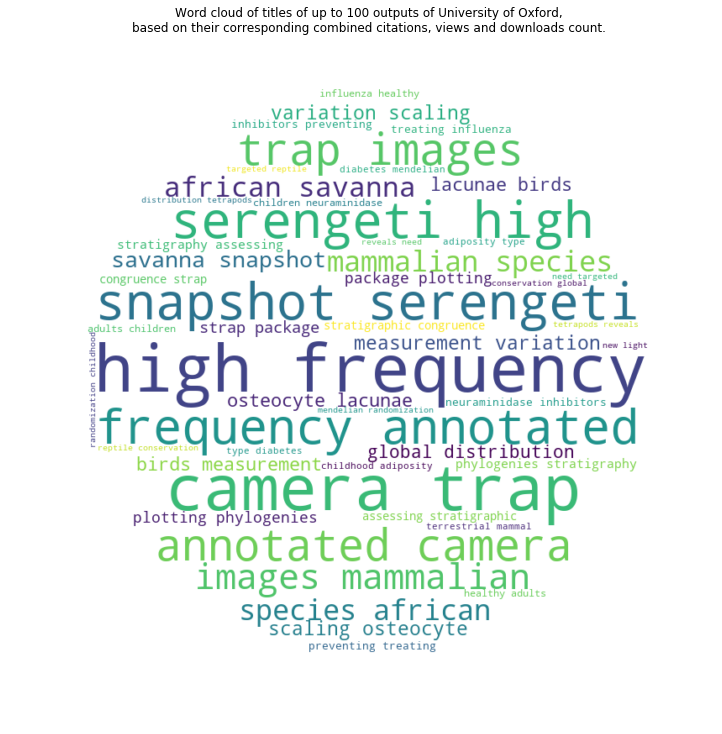

In [194]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import re

stopWords = set(STOPWORDS)
stopWords.update(['_','data','from','of','in','case','study'])

organization = data['organization']
organizationName = organization['name']

titleWords=[]
for metricCount in ['citationCount', 'viewCount', 'downloadCount']:
    for node in organization['works']['nodes']:
        for title in node['titles']:
            tokens = [t.lower() for t in re.split(' |:', str(title['title'])) if t.lower() not in stopWords] 
            for i in range(node[metricCount]):
                titleWords += tokens
     
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 345 ** 2
mask = 255 * mask.astype(int)
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopWords, 
                min_font_size = 10, 
                prefer_horizontal = 0.95,
                mask = mask).generate(" ".join(titleWords))
    
fig, ax = plt.subplots(1, 1, figsize = (10, 10), facecolor = None)
ax.set_title("Word cloud of titles of up to %d outputs of %s,\nbased on their corresponding combined citations, views and downloads count." % (query_params['maxOutputs'], organizationName))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

## Plot via [Vega Editor](https://vega.github.io/editor) an interactive matrix diagram of output authors' affiliations
Generate data in the format that you can use in [Vega Editor](https://vega.github.io/editor) to plot an interactive matrix diagram of [University of Oxford](https://ror.org/052gg0110)'s outputs author affiliations. In this diagram:
- Affiliations are values on X and Y axes, and 
- The rectangular cells in the matrix indicate that authors from the two respective affiliations shared at least one publication together.
- Each region, from the _affiliation to region_ mapping above, is shown by different colour: 
 - **brown** cell colour indicates that the corresponding affiliations are **not in the same geographic* region**; 
 - **any other** cell colour indicates that the corresponding affiliations are **in the same geographic region**. 
<br>

*For affiliation to geographic region mapping see below.

In [256]:
import json
from IPython.display import FileLink, FileLinks

# Map affiliations of authors of University of Oxford publications to regions
af2Loc = {
"University of Oxford" : "UK",
"University of Warwick" : "UK",
"University of Idaho" : "North America",
"University of Zurich" : "Europe",
"University of Aberdeen" : "UK",
"University of Sheffield" : "UK",
"University of Bergen" : "Europe",
"University of Tokyo" : "Asia",
"University of Arizona" : "North America",
"University of Connecticut" : "North America",
"University of Queensland" : "Australia/New Zealand",
"University of Southern Denmark" : "Europe",
"University College London" : "UK",
"University of Toronto" : "North America",
"University of Washington" : "North America",
"University of Amsterdam" : "Europe",
"University of Edinburgh" : "UK",
"University of California System" : "North America",
"University of Lincoln" : "UK",
"University of Vermont" : "North America",
"University of Western Australia" : "Australia/New Zealand",
"University of Helsinki" : "Europe",
"University of Bordeaux" : "Europe",
"University of Freiburg" : "Europe",
"University of Liège" : "Europe",
"University of Maryland, College Park" : "North America",
"University of Stirling" : "UK",
"University of Montpellier" : "Europe",
"University of Louisville" : "North America",
"University College Cork" : "Europe",
"University of Auckland" : "Australia/New Zealand",
"University of Exeter" : "UK",
"University of Minnesota" : "North America",
"University of Birmingham" : "UK",
"University of Bristol" : "UK",
"University of Córdoba" : "Europe",
"University of Extremadura" : "Europe",
"University of Lausanne" : "Europe",
"University of Otago" : "Australia/New Zealand",
"University of Paris-Sud" : "Europe",
"University of Cape Town" : "Africa",
"University of Groningen" : "Europe",
"University of Konstanz" : "Europe",
"University of Cambridge" : "UK",
"University of Oslo" : "Europe",
"University of the French West Indies and Guiana" : "Latin America",
"University of California, Davis" : "North America",
"University of Bath" : "Europe",
"University of Montreal" : "North America",
"University of the West of England" : "UK",
"University of Aveiro" : "Europe",
"University of Lisbon" : "Europe",
"University of Leicester" : "UK",
"University of Florida" : "North America",
"University of South Florida" : "North America",
"University of California, Irvine" : "North America",
"University of Gothenburg" : "Europe",
"University of Sussex" : "UK",
"University of Bern" : "Europe",
"University of Manitoba" : "North America",
"University of Southern California" : "North America",
"University of Technology Sydney" : "Australia/New Zealand",
"University of Southampton" : "UK",
"University of KwaZulu-Natal" : "Africa",
"Columbia University": "North America",
"Federal University of Rio Grande do Sul": "Latin America",
"Massey University": "Australia/New Zealand",
"Statens Serum Institut": "Europe",
"Swansea University": "UK",
"United States Department of Agriculture": "North America",
"National Museum of Nature and Science": "Asia",
"Natural History Museum and Institute": "Asia",
"Tohoku University": "Asia",
"Stony Brook University": "North America",
"Harvard University": "North America",
"Max Planck Institute for Demographic Research": "Europe",
"Princeton University": "North America",
"Radboud University Nijmegen": "Europe",
"Smithsonian Environmental Research Center": "North America",
"Stockholm University": "Europe",
"Institute of Vertebrate Paleontology and Paleoanthropology": "Asia",
"Royal Ontario Museum": "North America",
"Smithsonian Institution": "North America",
"Uppsala University": "Europe",
"Bond University": "Australia/New Zealand",
"Aarhus University": "Europe",
"Boston Children's Hospital": "North America",
"Boston University": "North America",
"Children's Hospital": "North America",
"American Museum of Natural History": "North America",
"Swarthmore College": "UK",
"Duquesne University": "North America",
"East China Normal University": "Asia",
"US Forest Service": "North America",
"Centre for Research on Ecology and Forestry Applications": "Europe",
"Swedish University of Agricultural Sciences": "Europe",
"Technical University Munich": "Europe",
"Institute of Cancer Research": "UK",
"Federal University of Lavraxs": "Latin America",
"Lancaster University": "UK",
"State University of Campinas": "Latin America",
"Council for Scientific and Industrial Research": "Africa",
"Florida International University": "North America",
"French National Institute for Agricultural Research": "Europe",
"German Center for Integrative Biodiversity Research": "Europe",
"Kyoto University": "Asia",
"Royal Holloway University of London": "UK",
"Smithsonian Tropical Research Institute": "North America",
"Wageningen University & Research": "Europe",
"Zoological Society of London": "UK",
"Emory University": "North America",
"McGill University": "North America",
"McGill University Health Centre": "North America",
"New York University": "North America",
"New York University School of Medicine": "North America",
"National Museum": "Unknown",
"Nederlands Instituut voor Ecologie": "Europe",
"Macquarie University": "Australia/New Zealand",
"Australian National University": "Australia/New Zealand",
"Bielefeld University": "Europe",
"British Antarctic Survey": "UK",
"Centre d'Ecologie Fonctionnelle et Evolutive": "Europe",
"Eötvös Loránd University": "Europe",
"Institute of Avian Research": "Europe",
"UNSW Australia": "Australia/New Zealand",
"Stellenbosch University": "Africa",
"Laboratoire de Neurosciences Cognitives": "Europe",
"Yale University": "North America",
"Chinese Academy of Sciences": "Asia",
"Department of Earth Sciences": "UK",
"Imperial College London": "UK",
"Aalto University": "Europe",
"Institute of Theoretical Physics": "Unknown",
"Mahidol University": "Asia",
"Royal Institute of Technology": "UK",
"Vanderbilt University": "Europe",
"Wellcome Trust": "UK",
"Max Planck Institute for Ornithology": "Europe",
"Santa Fe Institute": "North America",
"Lund University": "Europe",
"Cardiff University": "UK",
"Manchester Metropolitan University": "UK",
"Griffith University": "Australia/New Zealand",
"National Museums Scotland": "UK",
"Oregon State University": "North America",
"Rocky Mountain Biological Laboratory": "North America",
"Federal University of Alagoas": "Latin America",
"City, University of London": "UK",
"Commonwealth Scientific and Industrial Research Organisation": "Australia/New Zealand",
"National Autonomous University of Mexico": "Latin America",
"The Open University": "UK",
"Western Sydney University": "Australia/New Zealand",
"Forest Research": "UK",
"European Molecular Biology Laboratory": "Europe",
"Johns Hopkins University": "North America",
"National Institute of Allergy and Infectious Diseases": "North America",
"Rakai Health Sciences Program": "Africa",
"Federal University of Lavras": "Latin America"
}

# Map regions from the above mapping to ids of groups that will be shown in different colours the matrix diagram 
loc2Group = {
    "Africa": 1,
    "Asia": 2,
    "Australia/New Zealand": 3,
    "Europe": 4,
    "North America": 5,
    "UK": 6,
    "Latin America": 7,
    "Unknown": 8
}

# Initialise intermediate data structure to store: (srcAf, trgAf) -> number of shared publications 
srcAfTrgAf2Count = {}
# Initialise intermediate data structure to store: af --> Set of connected affs
# Note that the number of connected affs will determine the colour of each affiliation node
af2OtherAfs = {}
organization = data['organization']
organizationName = organization['name']

# Populate srcAfTrgAf2Count
allAffs = set()
for node in organization['works']['nodes']:
    affSet = set()
    for creator in node['creators']:
        for affiliation in creator['affiliation']:
            af = affiliation['name']
            affSet.add(af)
    affs = sorted(list(affSet))
    allAffs.update(affs)
    for af in affs:
        for af1 in affs:
            if af1 != af:
                if af < af1:
                    tuple = (af, af1)
                else: 
                    tuple = (af1, af)
                if af not in af2OtherAfs:
                    af2OtherAfs[af] = set()
                af2OtherAfs[af].add(af1)
                if af1 not in af2OtherAfs:
                    af2OtherAfs[af1] = set()
                af2OtherAfs[af1].add(af)   
                
                if tuple not in srcAfTrgAf2Count:
                    srcAfTrgAf2Count[tuple] = 0
                else:
                    srcAfTrgAf2Count[tuple] += 1                   

# Populate data structures needed for the matrix diagram visualisation 
idx = 0
af2idx = {}                    
nodes, links = [], []
for tuple in srcAfTrgAf2Count:
    if srcAfTrgAf2Count[tuple] > 0:
        srcAf = tuple[0]
        trgAf = tuple[1]
        for af in [srcAf, trgAf]:
            if af not in af2idx:
                af2idx[af] = idx
                if af in af2Loc:
                    loc = af2Loc[af]
                else:
                    loc = 'Unknown'
                grp = loc2Group[loc]
                nodes.append({"name": af, "group": grp, "index": idx})
                idx += 1
        links.append({"source": af2idx[srcAf], "target": af2idx[trgAf], "value": srcAfTrgAf2Count[tuple]})

for template_file in ['vega_by_group.json', 'vega_by_index.json']:
    with open(template_file,'r') as vega_template:
        content = eval(vega_template.read())
    for datum in content['data']:
        if datum["name"] == "nodes":
            datum["values"]["nodes"] = nodes
        elif datum["name"] == "edges":
            datum["values"]["links"] = links
    with open(template_file.replace('.json','.txt'), 'w') as f:
         json.dump(content, f)
    
display(Markdown(" \
In order to display the matrix diagram of [University of Oxford](https://ror.org/052gg0110)'s outputs' author affiliations, \
please do the following: \
<br />- Open [Vega Editor](https://vega.github.io/editor/#/custom/vega) in a separate tab or window; \
<br />- Click on: [vega_by_group.txt](vega_by_group.txt) or [vega_by_index.txt](vega_by_index.txt), depending on which matrix you wish to display; \
<br />- Copy the content of the file you selected; \
<br />- Paste it (overwriting the default text) into the left-hand side of the editor, as shown below:\
<br /><img src=\"vega_editor.png\" width=\"615\" height=\"1074\" />\
<br /><br />On the right-hand side you will see the matrix diagram, in which affiliations are values on X and Y axes, and the rectangle \
cells in the matrix indicate that authors from the two respective affiliations shared at least one publication together. \
<br /><br />Each region, from the _affiliation to region_ mapping above, is shown by different colour: \
<br />- **brown** cell colour indicates that the corresponding affiliations are **not in the same geographic region**; \
<br />- **any other** cell colour indicates that the corresponding affiliations are **in the same geographic region**. \
<br /><br />The matrix diagram files and the example images of the corresponding matrix diagrams for University of Oxford outputs are shown below: \
"))
display(Markdown("* [vega_by_group.txt](vega_by_group.txt) - a matrix diagram* in which publications from authors with affiliations in the same region are clustered together:<br>**Click [here](vega_by_group.svg) to see the diagram below in SVG format*<br> <img src=\"vega_by_group.png\" width=\"1300\" height=\"1000\" />"))
display(Markdown("* [vega_by_index.txt](vega_by_index.txt) - a matrix diagram* in which publications are clustered together irrespective of the author affiliations' regions:<br>**Click [here](vega_by_index.svg) to see the diagram below in SVG format*<br> <img src=\"vega_by_index.png\" width=\"1500\" height=\"1000\" /> "))

 In order to display the matrix diagram of [University of Oxford](https://ror.org/052gg0110)'s outputs' author affiliations, please do the following: <br />- Open [Vega Editor](https://vega.github.io/editor/#/custom/vega) in a separate tab or window; <br />- Click on: [vega_by_group.txt](vega_by_group.txt) or [vega_by_index.txt](vega_by_index.txt), depending on which matrix you wish to display; <br />- Copy the content of the file you selected; <br />- Paste it (overwriting the default text) into the left-hand side of the editor, as shown below:<br /><img src="vega_editor.png" width="615" height="1074" /><br /><br />On the right-hand side you will see the matrix diagram, in which affiliations are values on X and Y axes, and the rectangle cells in the matrix indicate that authors from the two respective affiliations shared at least one publication together. <br /><br />Each region, from the _affiliation to region_ mapping above, is shown by different colour: <br />- **brown** cell colour indicates that the corresponding affiliations are **not in the same geographic region**; <br />- **any other** cell colour indicates that the corresponding affiliations are **in the same geographic region**. <br /><br />The matrix diagram files and the example images of the corresponding matrix diagrams for University of Oxford outputs are shown below: 

* [vega_by_group.txt](vega_by_group.txt) - a matrix diagram* in which publications from authors with affiliations in the same region are clustered together:<br>**Click [here](vega_by_group.svg) to see the diagram below in SVG format*<br> <img src="vega_by_group.png" width="1300" height="1000" />

* [vega_by_index.txt](vega_by_index.txt) - a matrix diagram* in which publications are clustered together irrespective of the author affiliations' regions:<br>**Click [here](vega_by_index.svg) to see the diagram below in SVG format*<br> <img src="vega_by_index.png" width="1500" height="1000" /> 